# Bag of Words and tf-idf classification (JV)

Classification of publication day of week based on Bag of Words and Term Frequency — Inverse Document Frequency (tf-idf) analysis

## Packages

In [58]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, clear_output

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

## Training Data

For the Bag-of-Words and td-idf analysis, each document in the training data set is a concatenation of all of the hints for a particular puzzle, for a total of 9757 puzzles in the corpus.

In [13]:
xword_full = pd.read_csv('jv-xword-full.csv', converters={'Answer' : str, 'Hint' : str}, parse_dates = ['date'])

In [14]:
hints_per_puzzle = xword_full.groupby(['date'])['Hint'].agg(list).reset_index()
hints_per_puzzle['WeekdayNum'] = hints_per_puzzle['date'].dt.dayofweek
hints_per_puzzle['hints_joined'] = hints_per_puzzle['Hint'].apply(lambda x: " ".join(x))

hints_per_puzzle.sample(5)

,date,Hint,WeekdayNum,hints_joined
553,1995-07-21,"[1993 Bulls feat, Red letters, Place to work o...",4,1993 Bulls feat Red letters Place to work out ...
6987,2013-05-28,"[Native Kiwis, Big name in power tools, Educat...",1,Native Kiwis Big name in power tools Educated ...
1010,1996-10-31,"[School subj., Burst, Overfill, Puddin', Trian...",3,School subj. Burst Overfill Puddin' Triangular...
4849,2007-07-19,"[Restraint, Project Blue Book subject, Ex-, No...",3,Restraint Project Blue Book subject Ex- Not be...
1211,1997-05-20,"[Utters, Military plane acronym, Desertlike, W...",1,Utters Military plane acronym Desertlike Wyomi...


In [26]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# tf-idf Analysis

Note that both BoW and tf-idf analysis use the same variable names `X_train`, `X_test`, `y_train`, `y_test` so reset these variables before switching between the two.

## Feature extraction

In [72]:
tdidf = TfidfVectorizer()

X = tdidf.fit_transform(hints_per_puzzle['hints_joined'])
y = np.array(hints_per_puzzle['WeekdayNum'])

print(X.shape)
print(y)

(9757, 73889)
[5 6 0 ... 1 2 3]


In [73]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                 test_size = .2,
                                                 random_state = 514,
                                                 shuffle = True,
                                                 stratify = y)

## Truncated SVD

Like for the bag of words model, the data looks irreducible based on principal components

In [74]:
tsvd = TruncatedSVD(n_components = 10)

fit = tsvd.fit_transform(X)

print(tsvd.explained_variance_)

[0.00252596 0.00204065 0.00176555 0.00156402 0.00141823 0.00102148
 0.00094298 0.00087448 0.00082612 0.000805  ]


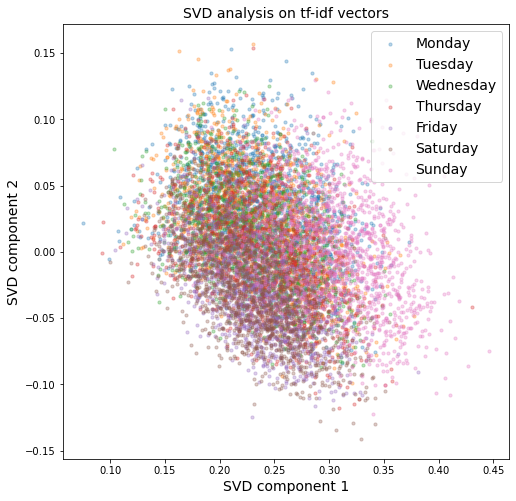

In [75]:
plt.figure(figsize=(8,8))

fit_df = pd.DataFrame(fit)
for i, dname in enumerate(weekdays):
    plt.scatter(fit[y==i,0], fit[y==i,1], label=dname, alpha=0.3, s=10)
plt.legend(fontsize=14)
plt.title("SVD analysis on tf-idf vectors", fontsize=14)
plt.xlabel("SVD component 1", fontsize=14)
plt.ylabel("SVD component 2", fontsize=14)
plt.show()

### Store model accuracy in dict

In [22]:
accuracies = {}
models = {}
pred = {}
cmats = {}

In [40]:
def custom_cmat_heatmap(cmat, accuracy, title=None, axis=ax):
    res = sns.heatmap(cmat, annot=True, ax=ax,cmap = plt.cm.Blues, annot_kws={'fontsize': 12}, cbar=False)
    
    ax.set_title(title + ', accuracy = %.3f' % accuracy, fontsize=16)
    ax.xaxis.set_ticklabels(weekdays, rotation=45, fontsize=14)
    ax.yaxis.set_ticklabels(weekdays, rotation='horizontal', fontsize=14)
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)

    for _, spine in res.spines.items():
        spine.set_visible(True)

## Feed Forward Network

### Model search

In [8]:
%%time

mlp = MLPClassifier(max_iter=1000)

parameter_space = {
    'hidden_layer_sizes': [(10,), (20,), (30,),],
    'alpha': [0.0001, 0.05],
}

mlp_GridSearchCV = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5, scoring='accuracy', verbose=5)
mlp_GridSearchCV.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Wall time: 1h 43min 8s


GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(10,), (20,), (30,)]},
             scoring='accuracy', verbose=5)

In [9]:
print('Best parameters found:\n', mlp_GridSearchCV.best_params_)

Best parameters found:
 {'alpha': 0.05, 'hidden_layer_sizes': (20,)}


In [10]:
means = mlp_GridSearchCV.cv_results_['mean_test_score']
stds = mlp_GridSearchCV.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, mlp_GridSearchCV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.487 (+/-0.028) for {'alpha': 0.0001, 'hidden_layer_sizes': (10,)}
0.493 (+/-0.024) for {'alpha': 0.0001, 'hidden_layer_sizes': (20,)}
0.492 (+/-0.031) for {'alpha': 0.0001, 'hidden_layer_sizes': (30,)}
0.509 (+/-0.020) for {'alpha': 0.05, 'hidden_layer_sizes': (10,)}
0.509 (+/-0.020) for {'alpha': 0.05, 'hidden_layer_sizes': (20,)}
0.507 (+/-0.023) for {'alpha': 0.05, 'hidden_layer_sizes': (30,)}


In [18]:
%%time

mlp = MLPClassifier(max_iter=1000, alpha=0.05)

parameter_space = {
    'hidden_layer_sizes': [(20,5), (20,10), (20,15), (20,20), (20,25), (20,30), (20,10,10), (20,20,20),],
}

mlp_GridSearchCV = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5, scoring='accuracy', verbose=5)
mlp_GridSearchCV.fit(X_train, y_train)

means = mlp_GridSearchCV.cv_results_['mean_test_score']
stds = mlp_GridSearchCV.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, mlp_GridSearchCV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print('Best parameters found:\n', mlp_GridSearchCV.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.405 (+/-0.101) for {'hidden_layer_sizes': (20, 5)}
0.408 (+/-0.048) for {'hidden_layer_sizes': (20, 10)}
0.463 (+/-0.034) for {'hidden_layer_sizes': (20, 15)}
0.464 (+/-0.026) for {'hidden_layer_sizes': (20, 20)}
0.462 (+/-0.010) for {'hidden_layer_sizes': (20, 25)}
0.451 (+/-0.040) for {'hidden_layer_sizes': (20, 30)}
0.328 (+/-0.113) for {'hidden_layer_sizes': (20, 10, 10)}
0.407 (+/-0.046) for {'hidden_layer_sizes': (20, 20, 20)}
Best parameters found:
 {'hidden_layer_sizes': (20, 20)}
Wall time: 2h 1min 58s


### Final NN Model

In [23]:
%%time

models['SLP'] = MLPClassifier(hidden_layer_sizes=(20,), alpha=0.05, max_iter=1000)
models['SLP'].fit(X_train, y_train)

Wall time: 10min 11s


MLPClassifier(alpha=0.05, hidden_layer_sizes=(20,), max_iter=1000)

In [25]:
pred['SLP'] = models['SLP'].predict(X_test)

accuracies['SLP'] = accuracy_score(y_test, pred['SLP'])
cmats['SLP'] = confusion_matrix(y_test, pred['SLP'], normalize='true')

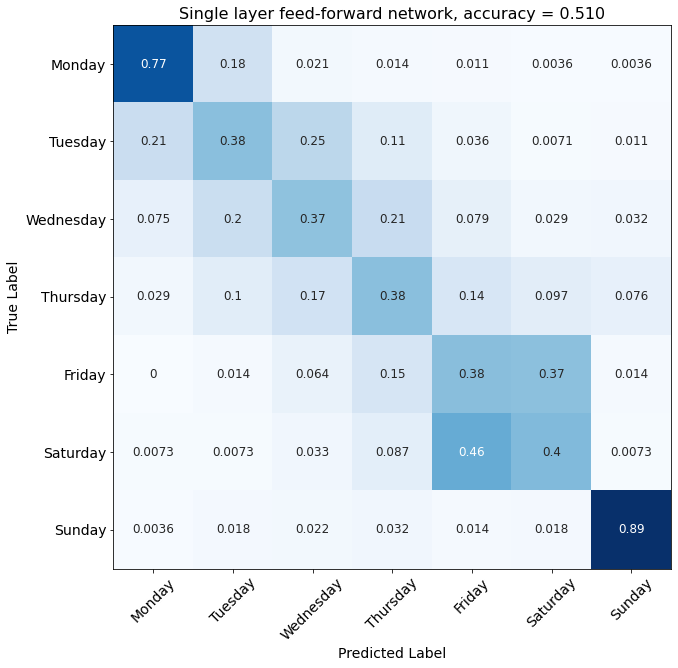

In [41]:
fig, ax = plt.subplots(figsize=(10,10))

title = "Single layer feed-forward network"

custom_cmat_heatmap(cmats['SLP'], accuracies['SLP'], title=title, axis=ax)

plt.show()

## SVM

### Model selection

In [14]:
%%time

kfold = StratifiedKFold(5, shuffle = True, random_state = 514)
c_vals = [0.5, 1.0, 2.0, 5.0]

accs_linearsvm = np.zeros((5, len(c_vals)))
accs_svm = np.zeros(5)

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    
    X_train_CV, y_train_CV = X_train[train_index], y_train[train_index]
    X_test_CV, y_test_CV = X_train[test_index], y_train[test_index]
    
    clear_output(wait=True)
    display(f"i = {i}")
    
    svm = SVC(kernel='linear', random_state=450)
    svm.fit(X_train_CV, y_train_CV)
    
    accs_svm[i] = accuracy_score( y_test_CV, svm.predict(X_test_CV) )
    
    for j,c in enumerate(c_vals):
        display('svm1')
        
        linearsvm = LinearSVC(C=c, random_state=450)
        linearsvm.fit(X_train_CV, y_train_CV)
        
        accs_linearsvm[i,j] = accuracy_score( y_test_CV, linearsvm.predict(X_test_CV) )
    i += 1

'i = 4'

'svm1'

'svm1'

'svm1'

'svm1'

Wall time: 11min 19s


In [27]:
accs_svm

array([0.50160154, 0.53555413, 0.53235106, 0.53042921, 0.52786675])

In [28]:
accs_linearsvm

array([[0.495836  , 0.49391416, 0.48942985, 0.4830237 ],
       [0.51057015, 0.50800769, 0.504164  , 0.50608584],
       [0.51441384, 0.51249199, 0.50992953, 0.50480461],
       [0.5169763 , 0.51121076, 0.5086483 , 0.50672646],
       [0.50288277, 0.49519539, 0.49071108, 0.48494555]])

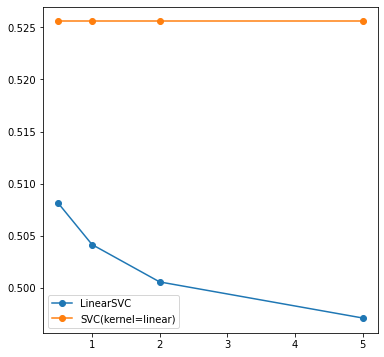

In [15]:
plt.figure(figsize=(6,6))
plt.plot(c_vals, np.mean(accs_linearsvm, axis=0), 'o-', label='LinearSVC')
plt.plot(c_vals, [np.mean(accs_svm, axis=0) for c in c_vals], 'o-', label='SVC(kernel=linear)')
plt.legend()
plt.show()

### Final SVM Model

In [42]:
models['SVM'] = SVC(kernel='linear', random_state=450)
models['SVM'].fit(X_train, y_train)

SVC(kernel='linear', random_state=450)

In [43]:
pred['SVM'] = models['SVM'].predict(X_test)

accuracies['SVM'] = accuracy_score(y_test, pred['SVM'])
cmats['SVM'] = confusion_matrix(y_test, pred['SVM'], normalize='true')

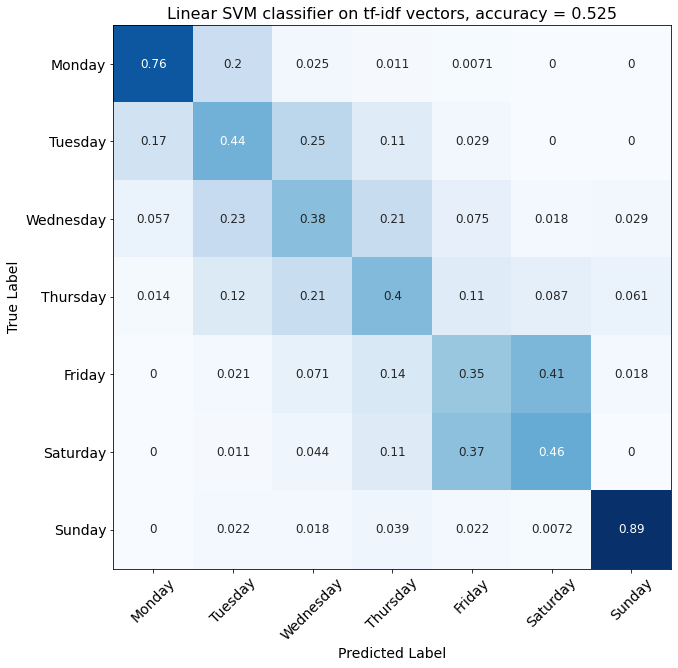

In [44]:
fig, ax = plt.subplots(figsize=(10,10))

title = "Linear SVM classifier on tf-idf vectors"

custom_cmat_heatmap(cmats['SVM'], accuracies['SVM'], title=title, axis=ax)

plt.show()

## Random Forest

### Model Selection

In [20]:
kfold = StratifiedKFold(5, shuffle = True, random_state = 514)

# Maybe increase?
depths = range(1,41)

accs_rf = np.zeros((5, len(depths)))

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_CV, y_train_CV = X_train[train_index], y_train[train_index]
    X_test_CV, y_test_CV = X_train[test_index], y_train[test_index]
    
    for j,d in enumerate(depths):
        clear_output(wait=True)
        display(f'i = {i}, depth = {d}')
        
        forest_clf = RandomForestClassifier(max_depth = d, random_state=514)
        forest_clf.fit(X_train_CV, y_train_CV)
        
        accs_rf[i,j] = accuracy_score( y_test_CV, forest_clf.predict(X_test_CV) )
    
    i += 1

'i = 4, depth = 40'

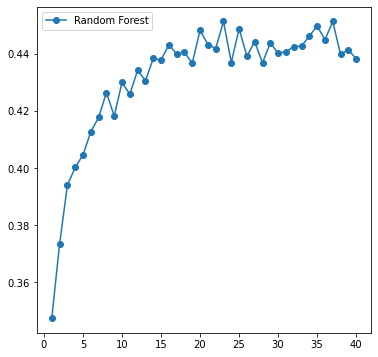

In [21]:
plt.figure(figsize=(6,6))
plt.plot(depths, np.mean(accs_rf, axis=0), 'o-', label='Random Forest')
plt.legend()
plt.show()

### Final Random Forest Model

In [47]:
%%time
models['RF'] = RandomForestClassifier(max_depth = 22)
models['RF'].fit(X_train, y_train)

Wall time: 7.37 s


RandomForestClassifier(max_depth=22)

In [48]:
pred['RF'] = models['RF'].predict(X_test)

accuracies['RF'] = accuracy_score(y_test, pred['RF'])
cmats['RF'] = confusion_matrix(y_test, pred['RF'], normalize='true')

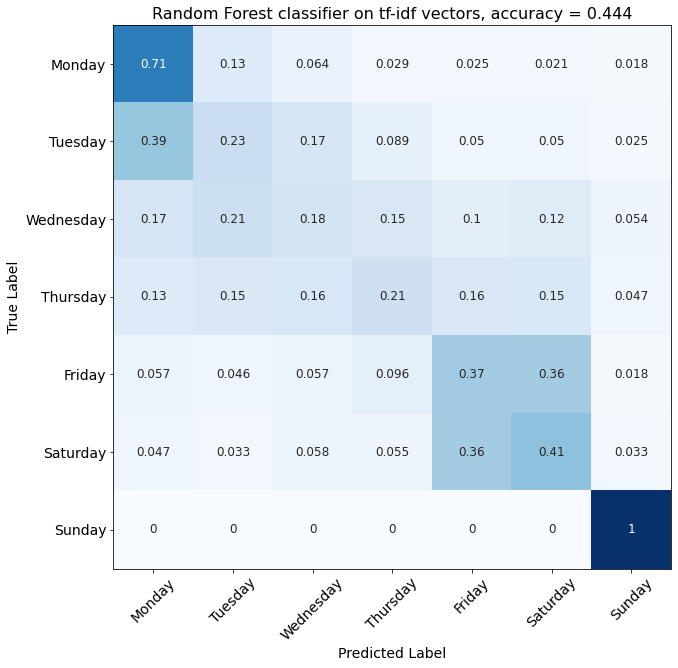

In [49]:
fig, ax = plt.subplots(figsize=(10,10))

title = "Random Forest classifier on tf-idf vectors"

custom_cmat_heatmap(cmats['RF'], accuracies['RF'], title=title, axis=ax)

plt.show()

## Boosted Decision Tree

### Model Selection

In [24]:
%%time

depths = range(1, 11)
estimators = range(1,16)
learning_rate = 0.5

accs_boost = np.zeros((len(estimators), len(depths)))

for i, n in enumerate(estimators):
    for j, d in enumerate(depths):
        clear_output(wait=True)
        display(f'estimator = {n} depth = {d}')
        
        ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d),
                    n_estimators = n,
                    algorithm="SAMME.R",
                    learning_rate = learning_rate
                                    )
        
        ada_clf.fit(X_train, y_train)
        accs_boost[i,j] = accuracy_score( y_test, ada_clf.predict(X_test) )

'estimator = 15 depth = 10'

Wall time: 32min 2s


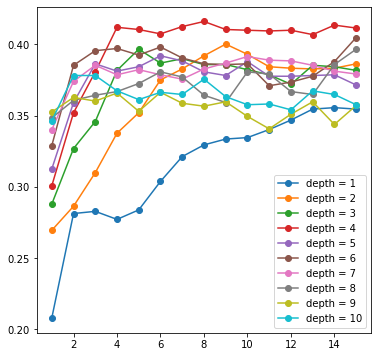

In [25]:
plt.figure(figsize=(6,6))
for d in depths:
    plt.plot(estimators, accs_boost[:,d-1], 'o-', label=f'depth = {d}')
plt.legend()
plt.show()

### Final Model

In [53]:
models['Boost'] = AdaBoostClassifier(DecisionTreeClassifier(max_depth=4),
                    n_estimators = 8,
                    algorithm="SAMME.R",
                    learning_rate = 0.5
                                    )
models['Boost'].fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.5, n_estimators=8)

In [54]:
pred['Boost'] = models['Boost'].predict(X_test)

accuracies['Boost'] = accuracy_score(y_test, pred['Boost'])
cmats['Boost'] = confusion_matrix(y_test, pred['Boost'], normalize='true')

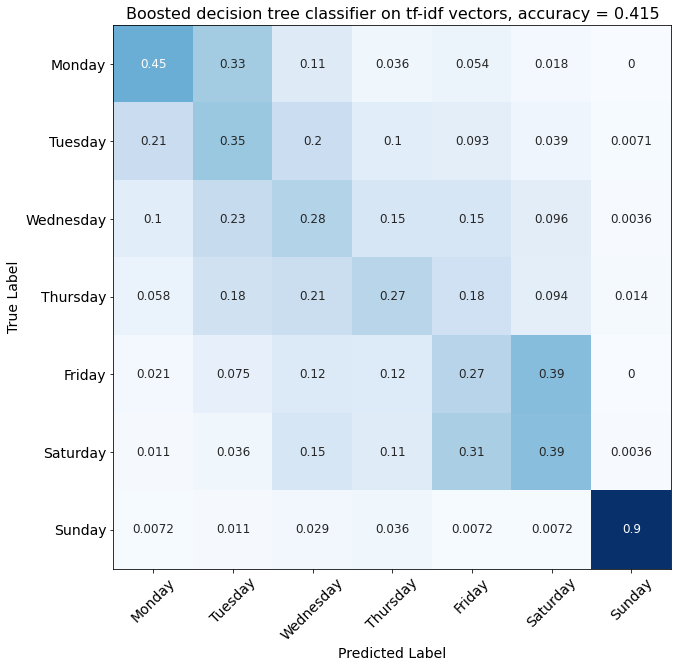

In [55]:
fig, ax = plt.subplots(figsize=(10,10))

title = "Boosted decision tree classifier on tf-idf vectors"

custom_cmat_heatmap(cmats['Boost'], accuracies['Boost'], title=title, axis=ax)

plt.show()

In [ ]:
tfidf_test_scores = {'NN': test_score_NN,
                    'SVM' : test_score_svm,
                     'Random Forest': test_score_rf,
                     'AdaBoost': test_score_boost}

random_guess = 1/7

plt.

# Bag of Words Analysis

Note that both BoW and tf-idf analysis use the same variable names `X_train`, `X_test` so reset these variables before switching between the two.

In [76]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(hints_per_puzzle['hints_joined'])
y = np.array(hints_per_puzzle['WeekdayNum'])

print(X.shape)
print(y)

(9757, 73889)
[5 6 0 ... 1 2 3]


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                 test_size = .2,
                                                 random_state = 514,
                                                 shuffle = True,
                                                 stratify = y)

In [80]:
accuracies_bow = {}
models_bow = {}
pred_bow = {}
cmats_bow = {}

## Truncated SVD

Looking at the explained variance, it's not really fair to restrict the analysis to the first two principal components. Sunday is well separated because the puzzles have more hints, but the rest of the week is not.

In [78]:
tsvd = TruncatedSVD(n_components = 10)

fit = tsvd.fit_transform(X)

print(tsvd.explained_variance_)

[31.1552247   9.06800955  7.28101545  5.61032321  4.26303066  3.54477866
  3.26876864  2.69256902  2.30852857  2.11646661]


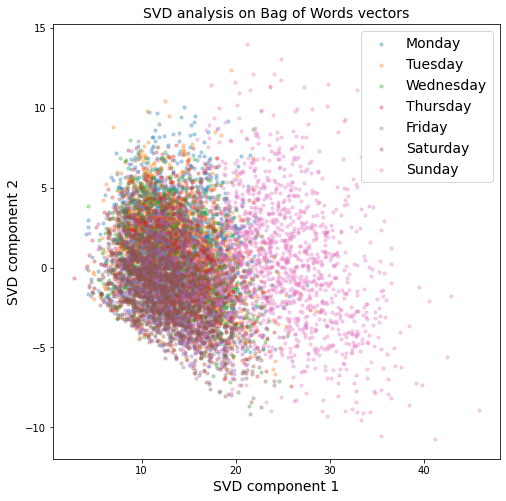

In [79]:
plt.figure(figsize=(8,8))

fit_df = pd.DataFrame(fit)
for i, dname in enumerate(weekdays):
    plt.scatter(fit[y==i,0], fit[y==i,1], label=dname, alpha=0.3, s=10)
plt.legend(fontsize=14)
plt.title("SVD analysis on Bag of Words vectors", fontsize=14)
plt.xlabel("SVD component 1", fontsize=14)
plt.ylabel("SVD component 2", fontsize=14)
plt.show()

## Feed Forward Network

### Final model

In [81]:
%%time

models_bow['SLP'] = MLPClassifier(hidden_layer_sizes=(20,), alpha=0.05, max_iter=1000)
models_bow['SLP'].fit(X_train, y_train)

Wall time: 3min 42s


MLPClassifier(alpha=0.05, hidden_layer_sizes=(20,), max_iter=1000)

In [82]:
pred_bow['SLP'] = models_bow['SLP'].predict(X_test)

accuracies_bow['SLP'] = accuracy_score(y_test, pred_bow['SLP'])
cmats_bow['SLP'] = confusion_matrix(y_test, pred_bow['SLP'], normalize='true')

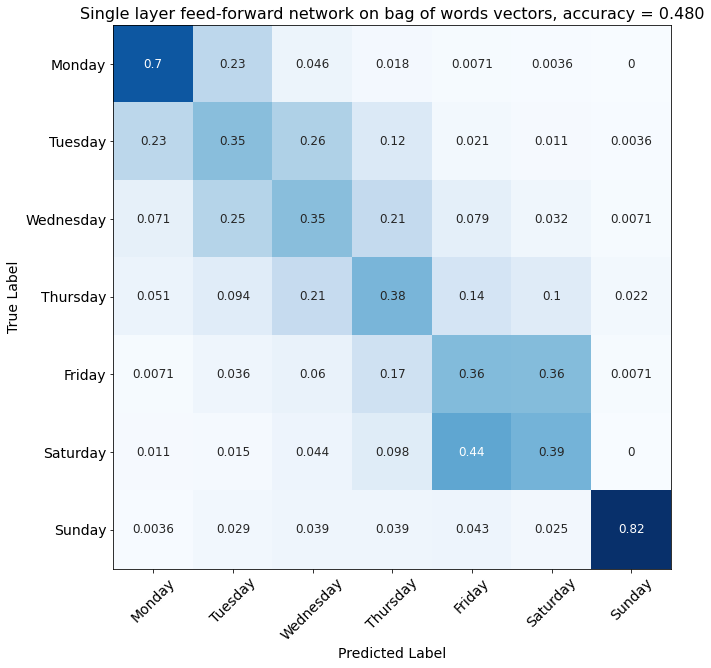

In [83]:
fig, ax = plt.subplots(figsize=(10,10))

title = "Single layer feed-forward network on bag of words vectors"

custom_cmat_heatmap(cmats_bow['SLP'], accuracies_bow['SLP'], title=title, axis=ax)

plt.show()

## SVM

Cross-validation for model selection yielded the same model as for the tf-idf analysis so it will not be included here.

### Final Model

In [84]:
%%time

models_bow['SVM'] = SVC(kernel='linear')
models_bow['SVM'].fit(X_train, y_train)

Wall time: 2min 2s


SVC(kernel='linear')

In [85]:
pred_bow['SVM'] = models_bow['SVM'].predict(X_test)

accuracies_bow['SVM'] = accuracy_score(y_test, pred_bow['SVM'])
cmats_bow['SVM'] = confusion_matrix(y_test, pred_bow['SVM'], normalize='true')

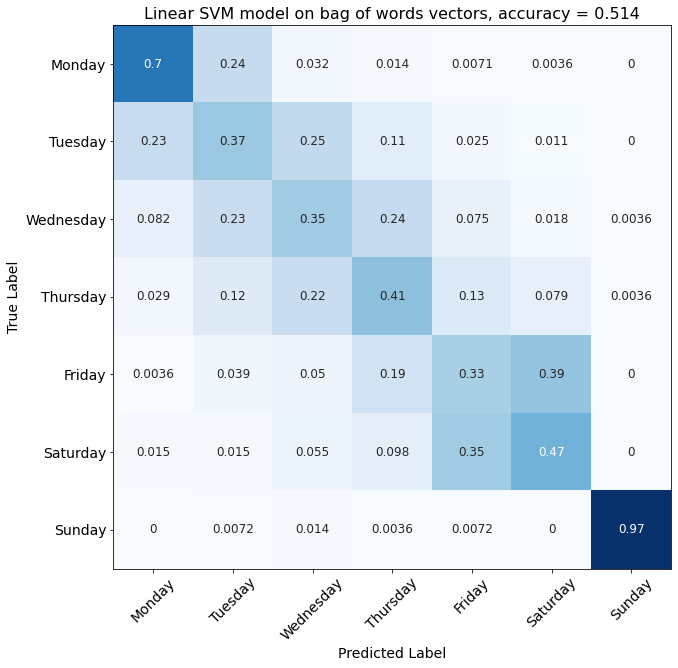

In [86]:
fig, ax = plt.subplots(figsize=(10,10))

title = "Linear SVM model on bag of words vectors"

custom_cmat_heatmap(cmats_bow['SVM'], accuracies_bow['SVM'], title=title, axis=ax)

plt.show()

## Random Forest

### Model Selection

In [87]:
%%time
kfold = StratifiedKFold(5, shuffle = True, random_state = 514)

# Maybe increase?
depths = range(1,41)

accs_rf = np.zeros((5, len(depths)))

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_CV, y_train_CV = X_train[train_index], y_train[train_index]
    X_test_CV, y_test_CV = X_train[test_index], y_train[test_index]
    
    for j,d in enumerate(depths):
        clear_output(wait=True)
        display(f'i = {i}, depth = {d}')
        
        forest_clf = RandomForestClassifier(max_depth = d, random_state=514)
        forest_clf.fit(X_train_CV, y_train_CV)
        
        accs_rf[i,j] = accuracy_score( y_test_CV, forest_clf.predict(X_test_CV) )
    
    i += 1

'i = 4, depth = 40'

Wall time: 18min 2s


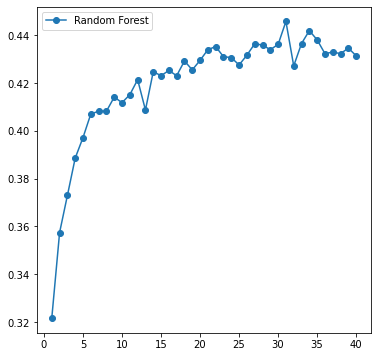

In [88]:
plt.figure(figsize=(6,6))
plt.plot(depths, np.mean(accs_rf, axis=0), 'o-', label='Random Forest')
plt.legend()
plt.show()

### Final Model

In [89]:
%%time

models_bow['RF'] = RandomForestClassifier(max_depth = 27)
models_bow['RF'].fit(X_train, y_train)

Wall time: 8.71 s


RandomForestClassifier(max_depth=27)

In [90]:
pred_bow['RF'] = models_bow['RF'].predict(X_test)

accuracies_bow['RF'] = accuracy_score(y_test, pred_bow['RF'])
cmats_bow['RF'] = confusion_matrix(y_test, pred_bow['RF'], normalize='true')

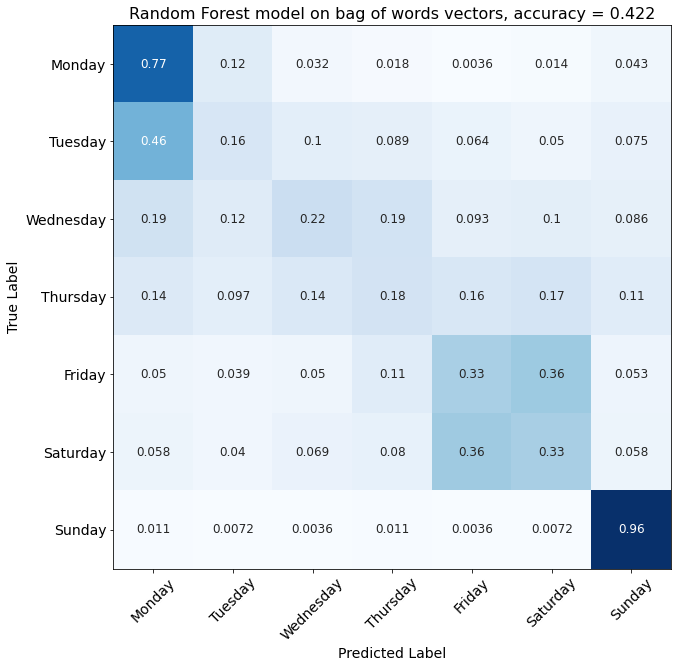

In [91]:
fig, ax = plt.subplots(figsize=(10,10))

title = "Random Forest model on bag of words vectors"

custom_cmat_heatmap(cmats_bow['RF'], accuracies_bow['RF'], title=title, axis=ax)

plt.show()

## Boosted Decision Tree

### Model Selection

In [92]:
%%time

depths = range(1, 5)
estimators = range(1,16)

kfold = StratifiedKFold(5, shuffle = True, random_state = 514)

accs_boost = np.zeros((5, len(estimators), len(depths)))

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    X_train_CV, y_train_CV = X_train[train_index], y_train[train_index]
    X_test_CV, y_test_CV = X_train[test_index], y_train[test_index]
    
    for j, n in enumerate(estimators):
        for k,d in enumerate(depths):
            clear_output(wait=True)
            display(f'i = {i}, est = {n}, depth = {d}')
            ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=d),
                        n_estimators = n,
                        algorithm="SAMME.R",
                        learning_rate = 0.5)
            
            ada_clf.fit(X_train, y_train)
            accs_boost[i,j,k] = accuracy_score( y_test, ada_clf.predict(X_test) )
    
    i += 1

'i = 4, est = 15, depth = 4'

Wall time: 23min 2s


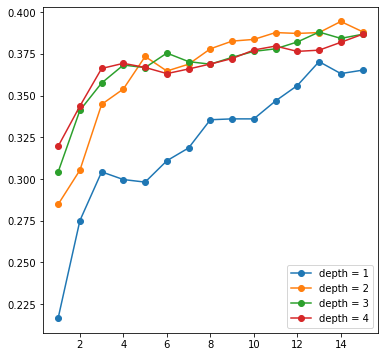

In [93]:
plt.figure(figsize=(6,6))
for d in depths:
    plt.plot(estimators, np.mean(accs_boost, axis=0)[:,d-1], 'o-', label=f'depth = {d}')
plt.legend()
plt.show()

### Final Model

In [94]:
%%time

models_bow['Boost'] = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2),
                        n_estimators = 14,
                        algorithm="SAMME.R",
                        learning_rate = 0.5)
models_bow['Boost'].fit(X_train, y_train)

Wall time: 5.94 s


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                   learning_rate=0.5, n_estimators=14)

In [95]:
pred_bow['Boost'] = models_bow['Boost'].predict(X_test)

accuracies_bow['Boost'] = accuracy_score(y_test, pred_bow['Boost'])
cmats_bow['Boost'] = confusion_matrix(y_test, pred_bow['Boost'], normalize='true')

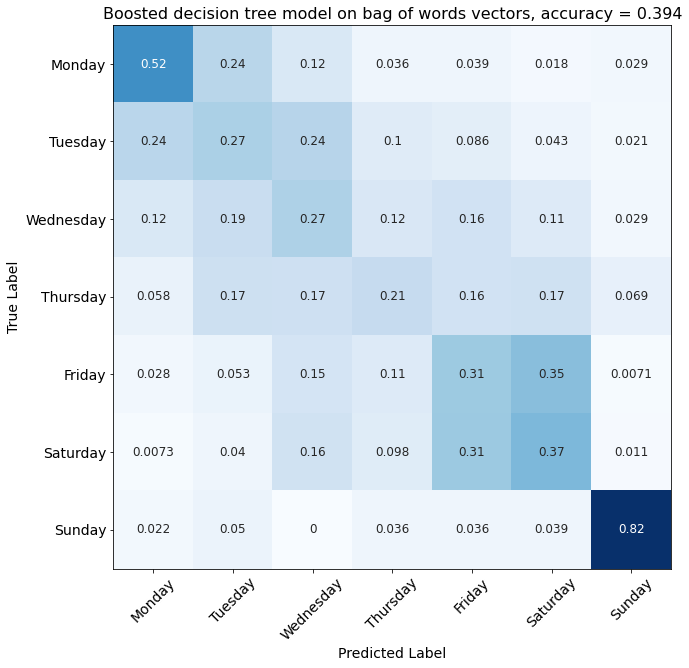

In [96]:
fig, ax = plt.subplots(figsize=(10,10))

title = "Boosted decision tree model on bag of words vectors"

custom_cmat_heatmap(cmats_bow['Boost'], accuracies_bow['Boost'], title=title, axis=ax)

plt.show()

# Summary

In [125]:
df = pd.DataFrame.from_dict([accuracies, accuracies_bow]).transpose().reset_index()
df

,index,0,1
0,SLP,0.509734,0.479508
1,SVM,0.524590,0.514344
2,RF,0.444160,0.421619
3,Boost,0.415471,0.394467


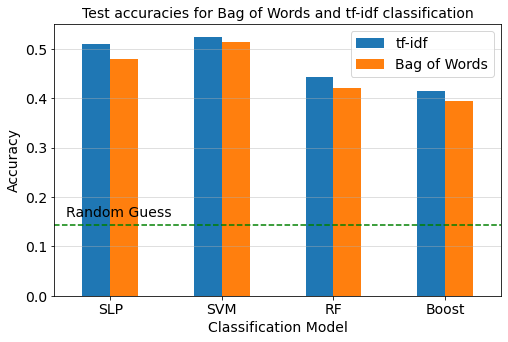

In [161]:
fig, ax = plt.subplots(figsize=(8, 5))


df.plot(x='index', y=[0,1], kind='bar', ax=ax, fontsize=14)

ax.legend(['tf-idf', 'Bag of Words'], fontsize=14)

ax.grid('on', which='major', axis='y', alpha=0.5)

ax.set_xlabel('Classification Model', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)

ax.xaxis.set_ticklabels(accuracies.keys(), rotation='horizontal', fontsize=14)

ax.set_title("Test accuracies for Bag of Words and tf-idf classification", fontsize=14)

ax.axhline(y=1/7, color='g', linestyle='--')
ax.text(-0.4,0.16,'Random Guess', fontsize=14)

plt.savefig('bow_tfidf_acc.png')
plt.show()